<a href="https://colab.research.google.com/github/cu2mauro/NN_matlab_bubble/blob/colabwork/ColabCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network to classify MATLAB bubble results

To build, train and test the CNN we use keras with the tensorflow backend.
Below we import the necessary modules.

In [1]:
import numpy as np #numerical
import pandas as pd #data analysis
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import scipy.io as sio
from scipy import interpolate
from scipy.interpolate import BSpline, make_interp_spline
import sys
%matplotlib inline
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from os.path import dirname, join as pjoin

In [3]:
from google.colab import drive
drive.mount('/content/drive');

Mounted at /content/drive


Load dataset: vectors of control points in X, actions in y.

In [96]:
mat = sio.loadmat('/content/drive/MyDrive/NN/NNtot')
data = mat['results']
X = np.reshape(np.vstack(data[:,0][:]),(len(data),12))
y = np.arctan(np.vstack(data[:,3][:])) #normalized with arctan for normalization
X = np.expand_dims(np.reshape(np.c_[np.zeros(len(y)),X,np.zeros(len(y))],(len(y),2,7)), axis=3) # add zeros for first X and last Y coordinates, reshape

In [5]:
print(X.shape,y.shape)

(3501, 2, 7, 1) (3501, 1)


Divide dataset into training (80%), validation (10%) and test set (10%)



In [87]:
Ntot = len(X)
tot_ind = np.arange(Ntot)
random.shuffle(tot_ind)
val_ind = tot_ind[int(Ntot*0.8):int(Ntot*0.9)]
train_ind = tot_ind[0:int(Ntot*0.8)]
test_ind = tot_ind[int(Ntot*0.9):]

In [88]:
X_train = X[train_ind]
y_train = y[train_ind]
X_val = X[val_ind]
y_val = y[val_ind]
X_test = X[test_ind]
y_test = y[test_ind]

In [89]:
X_train.shape

(2800, 2, 7, 1)

What is our data: show border spline-curve control points, domain, and corresponding action

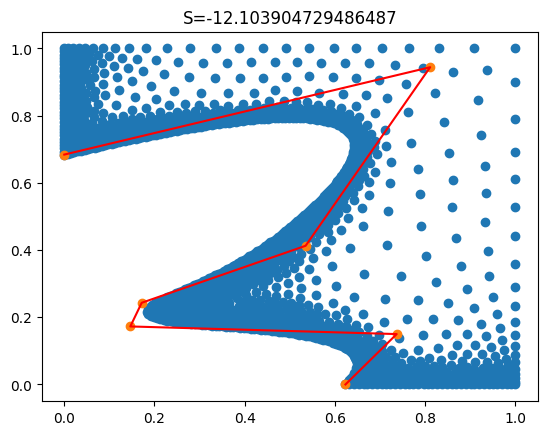

In [17]:
t = np.random.randint(len(X))
plt.scatter(np.transpose(data[t,1]['Points'][0][0])[0],np.transpose(data[t,1]['Points'][0][0])[1])
plt.scatter(X[t][0],X[t][1])
plt.plot(X[t][0],X[t][1],'r')
S = 'S='+str(y[t][0])
plt.title(S);
plt.show()

Build the CNN, compile and train/validate it

In [109]:
model = Sequential()
model.add(Conv2D(2, (2, 2), activation='relu', input_shape=(2, 7, 1), padding='same'))
model.add(Conv2D(4, (2, 2), activation='relu', padding='same'))
model.add(Conv2D(8, (2, 2), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))

In [ ]:
model.summary()

In [113]:
model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=keras.optimizers.Adam(learning_rate=0.005))

cnn_history = model.fit(X_train, y_train,
                        batch_size=128,
                        epochs=1000,
                        verbose=1,
                        validation_data=(X_val, y_val))

Epoch 1/1000
22/22 [==============================] - 2s 31ms/step - loss: 0.2923 - val_loss: 0.5637
Epoch 2/1000
22/22 [==============================] - 0s 5ms/step - loss: 0.1751 - val_loss: 0.5411
Epoch 3/1000
22/22 [==============================] - 0s 6ms/step - loss: 0.1525 - val_loss: 0.5692
Epoch 4/1000
22/22 [==============================] - 0s 6ms/step - loss: 0.1489 - val_loss: 0.5370
Epoch 5/1000
22/22 [==============================] - 0s 6ms/step - loss: 0.1461 - val_loss: 0.5460
Epoch 6/1000
22/22 [==============================] - 0s 6ms/step - loss: 0.1465 - val_loss: 0.5598
Epoch 7/1000
22/22 [==============================] - 0s 6ms/step - loss: 0.1496 - val_loss: 0.6000
Epoch 8/1000
22/22 [==============================] - 0s 6ms/step - loss: 0.1711 - val_loss: 0.5590
Epoch 9/1000
22/22 [==============================] - 0s 6ms/step - loss: 0.1547 - val_loss: 0.5377
Epoch 10/1000
22/22 [==============================] - 0s 6ms/step - loss: 0.1541 - val_loss: 0.546

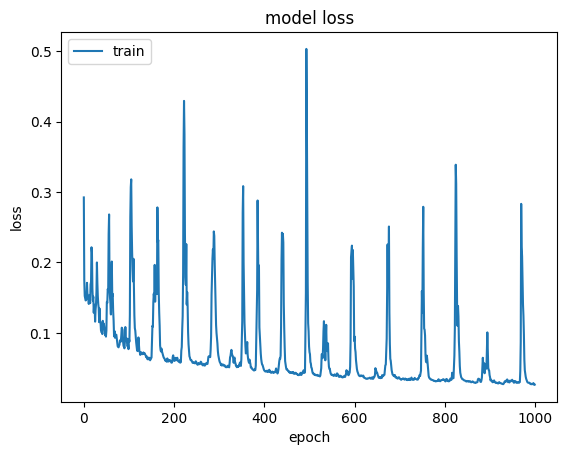

In [114]:
plt.plot(cnn_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [115]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score)
y_pred_cnn2 = model.predict(X_test)

Test accuracy: 0.9939529895782471
11/11 [==============================] - 0s 4ms/step


In [116]:
X[1]

array([[[0.        ],
        [0.13692956],
        [0.21521946],
        [0.15918917],
        [0.19961857],
        [0.06051979],
        [0.62343802]],

       [[0.28777351],
        [0.53166684],
        [0.68040489],
        [0.49416021],
        [0.529011  ],
        [0.44292401],
        [0.        ]]])

In [145]:
Xn=np.array([[  0.,0.155291427061512, 0.300000000000000, 0.424264068711929, 0.519615242270663, 0.579555495773441, 0.600000000000000],
[   0.700000000000000, 0.676148078402348, 0.606217782649107, 0.494974746830583, 0.350000000000000, 0.181173331571764, 0.]])
Xn=np.expand_dims(Xn, axis=2)
Xn=np.expand_dims(Xn, axis=0)

In [146]:
print(np.tan(model.predict(Xn)))

1/1 [==============================] - 0s 26ms/step
[[-1.3529532]]
